In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[Kaggle Dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data)

In [3]:
%pip install catboost xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Load dataset

In [69]:
folder_path = "/content/drive/MyDrive/Power BI/Projects/Brazilian E-Commerce Public Dataset by Olist/Dataset"

#load the cleaned,merged dataset
df = pd.read_csv(folder_path + '/' +'Merged_df.csv')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   delivery_time_days             115037 non-null  float64
 5   estimated_time_days            118434 non-null  int64  
 6   delay_vs_estimate              115037 non-null  float64
 7   order_year                     118434 non-null  int64  
 8   order_month                    118434 non-null  object 
 9   payment_sequential             118431 non-null  float64
 10  payment_type                   118431 non-null  object 
 11  payment_installments           118431 non-null  float64
 12  payment_value                 

# Features and target

In [71]:
features = [
    'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm',
    'product_photos_qty', 'product_description_lenght', 'product_category_name_english',
    'freight_value', 'delivery_time_days', 'delay_vs_estimate',
    'review_score', 'order_month', 'order_year', 'payment_type', 'payment_installments'
]

In [72]:
target = 'Repeating_customer'

In [73]:
X = df[features]
y = df[target]

In [74]:
y.value_counts()

,count
Repeating_customer,
0,114112
1,4322


-Calss imbalance

-Need to implement balancing techniques

# Encode categorical features for models that don't handle them natively

In [75]:
categorical_cols = ['product_category_name_english', 'order_month', 'payment_type']
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))


/tmp/ipython-input-3565425995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/tmp/ipython-input-3565425995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/tmp/ipython-input-3565425995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [76]:
from sklearn.impute import SimpleImputer
import numpy as np

# Identify numerical columns that might contain NaNs (excluding encoded categorical ones)
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# Initialize SimpleImputer
# You can choose a different strategy like 'median' or 'most_frequent'
imputer = SimpleImputer(strategy='mean')

# Apply imputation to the numerical columns of X
X_imputed = X.copy() # Create a copy to avoid SettingWithCopyWarning
X_imputed[numerical_cols] = imputer.fit_transform(X_imputed[numerical_cols])

# Now apply SMOTE on the imputed data
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_imputed, y)

print("Shape of original data:", X.shape)
print("Shape of resampled data:", X_resampled.shape)
print("\nValue counts of original target:", y.value_counts())
print("Value counts of resampled target:", y_resampled.value_counts())

Shape of original data: (118434, 15)
Shape of resampled data: (228224, 15)

Value counts of original target: Repeating_customer
0    114112
1      4322
Name: count, dtype: int64
Value counts of resampled target: Repeating_customer
0    114112
1    114112
Name: count, dtype: int64


# Split train/test

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Define models and parameter grids

In [78]:
models = {
    'CatBoost': CatBoostClassifier(verbose=0, random_seed=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

In [79]:
param_grids = {
    'CatBoost': {
        'iterations': [200, 400, 600],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5]
    },
    'XGBoost': {
        'n_estimators': [200, 400, 600],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.9, 1.0]
    },
    'RandomForest': {
        'n_estimators': [200, 400, 600],
        'max_depth': [4, 6, 8, None],
        'min_samples_split': [2, 5, 10]
    },
    'LightGBM': {
        'n_estimators': [200, 400, 600],
        'max_depth': [4, 6, 8, -1],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 70]
    }
}

# Perform Randomized Search for each model

In [18]:
best_models = {}

In [19]:
for name in models:
    print(f"\n🔹 Tuning {name}...")
    model = models[name]
    param_grid = param_grids[name]

    search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=10,          # number of random combinations
        scoring='roc_auc',
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f"✅ Best parameters for {name}: {search.best_params_}")


🔹 Tuning CatBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best parameters for CatBoost: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 400, 'depth': 8}

🔹 Tuning XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:01:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best parameters for XGBoost: {'subsample': 0.9, 'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.1}

🔹 Tuning RandomForest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Best parameters for RandomForest: {'n_estimators': 400, 'min_samples_split': 5, 'max_depth': None}

🔹 Tuning LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 91290, number of negative: 91289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3819
[LightGBM] [Info] Number of data points in the train set: 182579, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> initscore=0.000011
[LightGBM] [Info] Start training from score 0.000011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

# Evaluate all best models

In [80]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred))


CatBoost Performance:
Accuracy: 0.9708839960565232
ROC AUC: 0.9895765605247039
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     22823
           1       1.00      0.94      0.97     22822

    accuracy                           0.97     45645
   macro avg       0.97      0.97      0.97     45645
weighted avg       0.97      0.97      0.97     45645


XGBoost Performance:
Accuracy: 0.9833935808960456
ROC AUC: 0.9908844858609511
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     22823
           1       1.00      0.97      0.98     22822

    accuracy                           0.98     45645
   macro avg       0.98      0.98      0.98     45645
weighted avg       0.98      0.98      0.98     45645


RandomForest Performance:
Accuracy: 0.9852119618797239
ROC AUC: 0.9962548513342111
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     

#Prepare new customer data

In [81]:
new_data = pd.DataFrame({
    'product_weight_g': [1200, 800, 1500],
    'product_length_cm': [30, 20, 40],
    'product_height_cm': [10, 8, 12],
    'product_width_cm': [15, 10, 20],
    'product_photos_qty': [3, 2, 4],
    'product_description_lenght': [800, 500, 1000],
    'product_category_name_english': ['health_beauty', 'arts_and_craftmanship', 'furniture_decor'],
    'freight_value': [20.5, 5.0, 50.0],
    'delivery_time_days': [5, 3, 7],
    'delay_vs_estimate': [0.5, 0, 1.0],
    'review_score': [4.0, 5.0, 3.0],
    'order_month': ['May', 'June', 'July'],
    'order_year': [2021, 2021, 2021],
    'payment_type': ['credit_card', 'boleto', 'credit_card'],
    'payment_installments': [2, 1, 3]
})

df = pd.concat([df, new_data], ignore_index=True)




#Encode categorical features same as training

In [83]:
categorical_cols = ['product_category_name_english', 'order_month', 'payment_type']
label_encoders = {} # Store encoders in a dictionary

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on the full combined data to ensure all possible categories are seen
    le.fit(pd.concat([X[col].astype(str), df[col].astype(str)]))
    # Transform new customers data
    df[col] = le.transform(df[col].astype(str))
    # Store the fitted encoder
    label_encoders[col] = le

#Predict probabilities using the best model

In [84]:
best_model = best_models['RandomForest']
repeat_probs = best_model.predict_proba(df[features])[:,1]
df['repeat_prob'] = repeat_probs

In [85]:
# Use the stored label encoder for inverse transformation
df['product_category_name_english'] = label_encoders['product_category_name_english'].inverse_transform(
    df['product_category_name_english'].astype(int)
)

# Rank customers by likelihood to repeat

In [86]:

ranked_customers = df.sort_values(by='repeat_prob', ascending=False)
print("\nCustomers ranked by probability to repeat purchase:\n")
print(ranked_customers[['product_category_name_english', 'repeat_prob']])


Customers ranked by probability to repeat purchase:

       product_category_name_english  repeat_prob
112371                          toys     0.814768
112370                          toys     0.814768
26017                  watches_gifts     0.800744
100675                          toys     0.787536
13044                           toys     0.783607
...                              ...          ...
9052                            toys     0.015667
9053                            toys     0.015667
9055                            toys     0.015667
9054                            toys     0.015667
9056                            toys     0.015667

[118437 rows x 2 columns]


In [87]:
df['predicted_repeat'] = (df['repeat_prob'] > 0.05).astype(int)


In [91]:
print(df[['product_category_name_english', 'repeat_prob']].tail(3))

       product_category_name_english  repeat_prob
118434                 health_beauty     0.386105
118435         arts_and_craftmanship     0.125294
118436               furniture_decor     0.403292


**Interpretation:**

Furniture & Decor (0.403) → Highest probability of repeat purchases.
→ Suggests customers are more likely to return for interior or lifestyle-related products.

Health & Beauty (0.386) → Moderate probability of repeat behavior.
→ Indicates consistent demand; customers may repurchase after product usage.

Arts & Craftsmanship (0.125) → Lower repeat probability.
→ Indicates one-time or occasional purchases; consider retention strategies like bundle offers or creative promotions.

**Important features for predicting Repeating Customers**

In [88]:
import matplotlib.pyplot as plt

feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
importance_df.sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
10,review_score,0.150565
12,order_year,0.139349
13,payment_type,0.111768
14,payment_installments,0.094005
11,order_month,0.088983
4,product_photos_qty,0.052050
5,product_description_lenght,0.049186
9,delay_vs_estimate,0.044420
6,product_category_name_english,0.044268
0,product_weight_g,0.042123


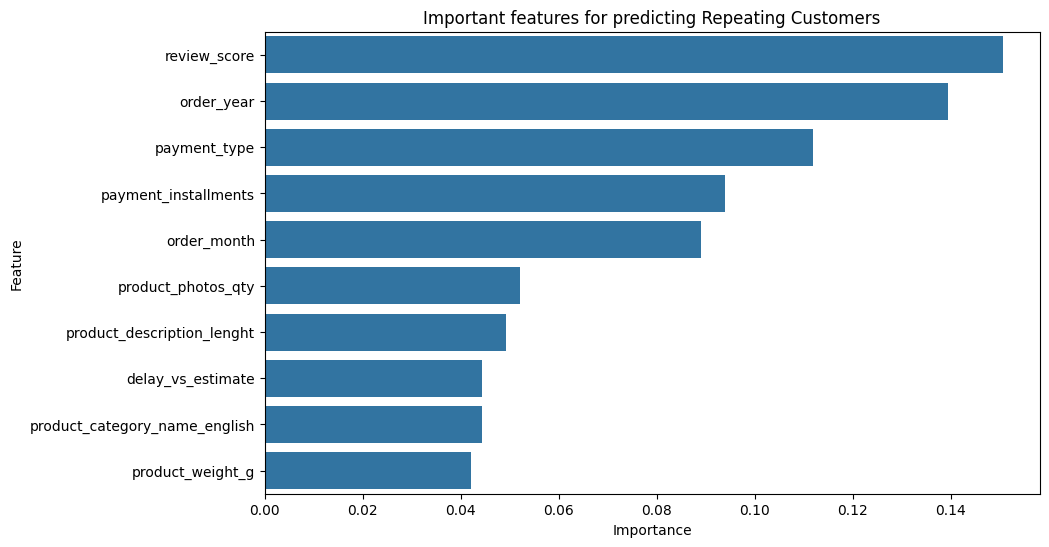

In [93]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False).head(10))
plt.title("Important features for predicting Repeating Customers")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()